In [372]:
from skimage.filters import butterworth
from skimage.filters import median

import skimage
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import cv2
from scipy.linalg import dft


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz
    from scipy.fft import fft, fftfreq, ifft



ch = pd.read_csv("GPR_ele_drone.txt", delim_whitespace=True,
          header=None, names=["Elev","Index"])
tr = pd.read_csv("trace.txt", delim_whitespace=True,
          header=None, names=["GPR_points"])

N = 110
max = 0

size = np.zeros(shape=(N), dtype=int)
size2 = np.zeros(shape=(N), dtype=int)

for i in np.arange(1,N+1,1):
    tm = ch.loc[ch["Index"]==i,["Elev"]]
    size[i-1] = np.size(tm)
   
max = np.max(size)
    
print("max number of GNSS points",max)

for i in np.arange(1,N+1,1):
    size2[i-1] = tr["GPR_points"][i-1]
#    print(size2[i-1])
min = np.min(size2)
print("min number of GPR points",min)

#The shape of final output
Elev_ch4 = np.zeros(shape=(N,min))
Elev_ch5 = np.zeros(shape=(N,min))


max number of GNSS points 1525
min number of GPR points 1498


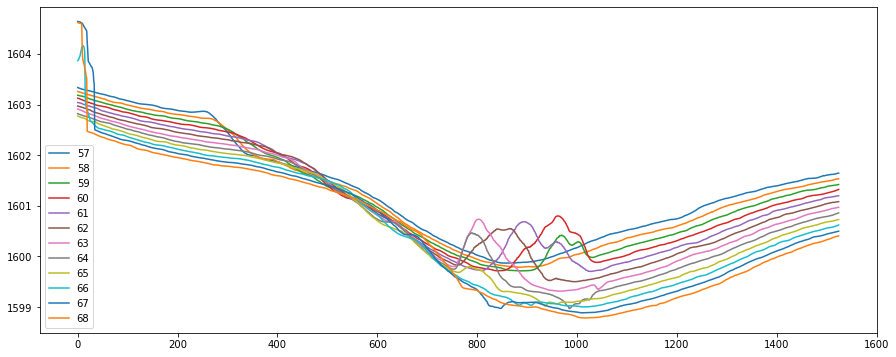

In [373]:
GNSS_drone = np.zeros(shape=(N,max))
GNSS_corr = np.zeros(shape=(N,max))
#GNSS_corr2 = np.zeros(shape=(N,max))

for n in np.arange(0,N,1):
#    print("++++++")
#    print("n=",n)
#    print("++++++")
    tm = ch.loc[ch["Index"]==n,["Elev"]]
    
    tm_size = np.size(tm)

    for j in np.arange(0,tm_size,1):
        GNSS_drone[n][j] = tm["Elev"][j+sum(size[:(n)])]
        
#trech piles
s = 57
e = 69

#van position
#s = 66
#s = 68
for t in np.arange(s,e,1):
    plt.plot(GNSS_drone[t][:])
plt.legend(np.arange(s,e,1))

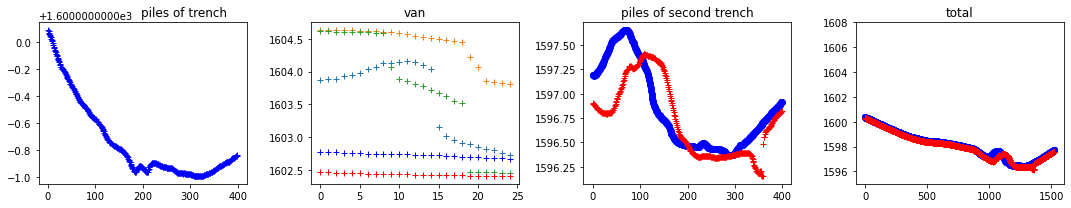

In [374]:
plt.rcParams["figure.figsize"] = (15,3)

plt.subplot(1,4,1)
plt.plot(GNSS_drone[66][700:1100],"b+")
#plt.title("piles of trench", position=(-1,-0.5))
plt.title("piles of trench", position=(0.7,0))

plt.subplot(1,4,2)
plt.plot(GNSS_drone[65][0:25],"b+")
plt.plot(GNSS_drone[66][0:25],"+")
plt.plot(GNSS_drone[67][0:25],"+")
plt.plot(GNSS_drone[68][0:25],"+")
plt.plot(GNSS_drone[69][0:25],"r+")

plt.title("van", position=(0.5,3))

plt.subplot(1,4,3)
plt.plot(GNSS_drone[100][1000:1400],"bo")
plt.plot(GNSS_drone[101][1000:1400],"r+")
plt.title("piles of second trench")


plt.subplot(1,4,4)
plt.plot(GNSS_drone[100][:],"bo")
plt.plot(GNSS_drone[101][:],"r+")
plt.title("total")

plt.ylim(1595,1608)

plt.tight_layout()

#print(GNSS_drone[69][0:25])

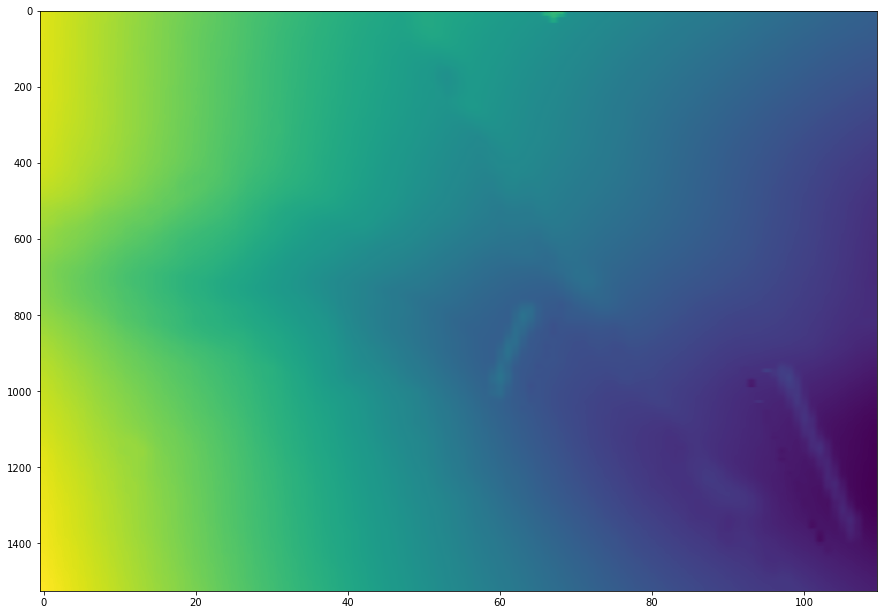

In [375]:
plt.rcParams["figure.figsize"] = (15,30)
plt.imshow(GNSS_drone.T, aspect=0.05)

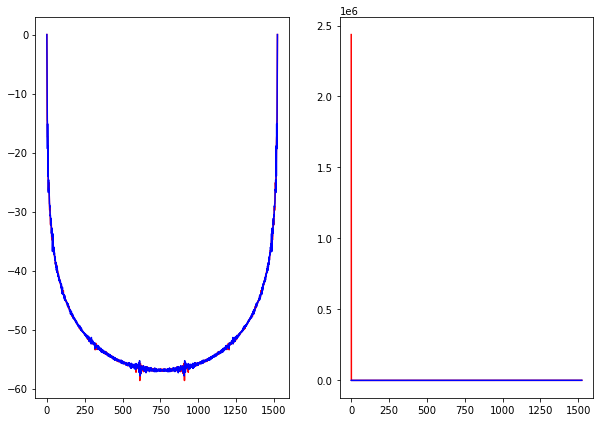

In [376]:
plt.rcParams["figure.figsize"] = (10,7)
y_real = np.zeros(shape=(N, max))
y_imag = np.zeros(shape=(N, max))
y_mag = np.zeros(shape=(N,max))
dB = np.zeros(shape=(N,max))

#Fourier Transform
for i in np.arange(0,N,1):
    y=np.fft.fft(GNSS_drone[i][:])
    y_real[i][:] = y.real
    y_imag[i][:] = y.imag   
    y_mag[i][:] = np.abs(y)    
    dB[i][:] = 10 * np.log10( (y_mag[i][:])**2 / np.max(y_mag[i][1:])**2 ) #decibel

plt.subplot(1,2,1)
plt.plot(dB[107][1:],"r")
plt.plot(dB[100][1:],"b")

plt.subplot(1,2,2)
plt.plot(y_real[107][:],"r")
plt.plot(y_imag[100][:],"b")


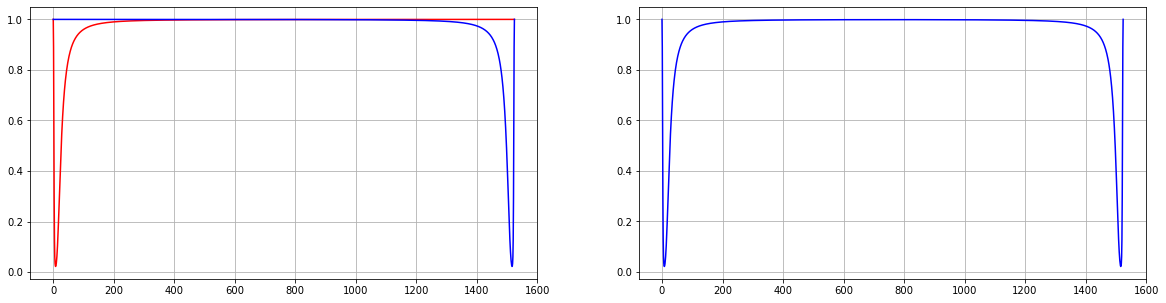

In [877]:
B = np.zeros(shape=(max,1))
B2 = np.zeros(shape=(max,1))

#band-pass filter
f_h = 3
f_b = 20

n = 2

r = 1

for f in range(0,max,1):
    B[f] = r * np.sqrt(1.0-(1.0/(1.0+( (f/f_h)**(2*n)) ))) * np.sqrt(1.0-( ((f/f_b)**(2*n))/(1+(f/f_b)**(2*n)) ))

B2 = 1 - B

B3 = np.flipud(B2)

plt.rcParams["figure.figsize"] = (20,5)
plt.subplot(1,2,1)
plt.plot(B2,"r") 
plt.plot(B3,"b") 
plt.grid()

B4 = B2 + B3 - 1
plt.subplot(1,2,2)
plt.plot(B4,"b") 

plt.grid()

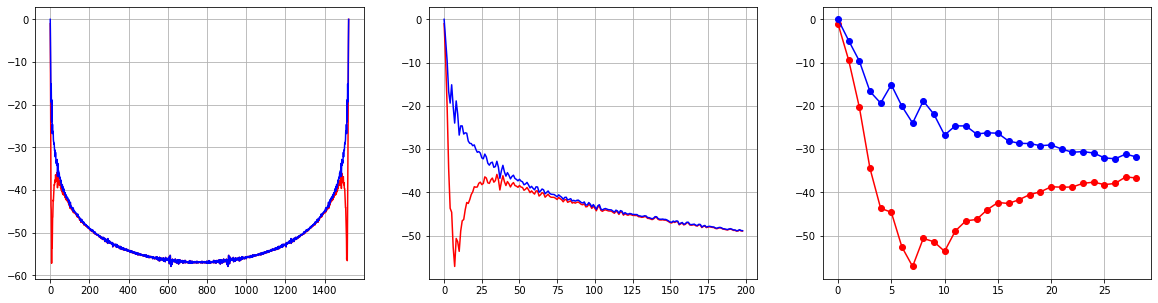

In [878]:
#apply band-pass filter
bpf = np.zeros(shape=(N,max))
dB2 = np.zeros(shape=(N,max))

for i in np.arange(0,N,1): 
    for f in np.arange(0,max,1):
        bpf[i][f] = B4[f] * y_mag[i][f]
    for f in np.arange(0,max,1):
        dB2[i][f] = 10 * np.log10( (bpf[i][f])**2 / np.max(bpf[i][1:])**2 ) #decibel

#plot filtered graphs
plt.subplot(1,3,1)
plt.plot(dB2[100][1:],"r")
plt.plot(dB[100][1:],"b")
plt.grid()

plt.subplot(1,3,2)
plt.plot(dB2[100][1:200],"r")
plt.plot(dB[100][1:200],"b")
plt.grid()

#plt.subplot(1,3,3)
#for i in np.arange(10,20,1):
#    plt.plot(dB2[i][1:],"r")
#plt.grid()


plt.subplot(1,3,3)
plt.plot(dB2[100][1:30],"ro-")
plt.plot(dB[100][1:30],"bo-")
plt.grid()


In [879]:
bpf_real = np.zeros(shape=(N,max))
bpf_imag = np.zeros(shape=(N,max))
bpf2 = np.zeros(shape=(N,max),dtype="complex")

for i in np.arange(0,N,1): 
    for f in np.arange(0,max,1):
        bpf_real[i][f] = B4[f] * y_real[i][f]
        bpf_imag[i][f] = B4[f] * y_imag[i][f]

for i in np.arange(0,N,1): 
    for f in np.arange(0,max,1):
        bpf2[i][f] = complex(bpf_real[i][f],bpf_imag[i][f])

#Inverse Fourier Transform
y2 = np.fft.ifft(bpf2)

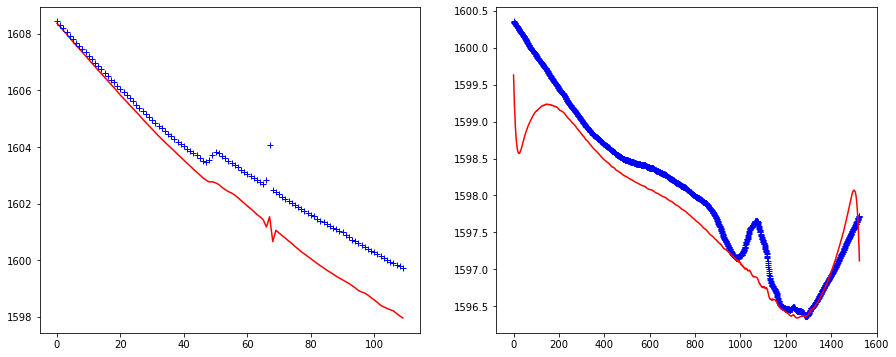

In [880]:
plt.rcParams["figure.figsize"] = (15,6)

f = 20
plt.subplot(1,2,1)
plt.plot(y2.real[:,f],"r-")
plt.plot(GNSS_drone[:,f],"b+")

n = 100
plt.subplot(1,2,2)

plt.plot(GNSS_drone[n,:],"b+")
plt.plot(y2.real[n,:],"r-")

Text(0.5, 1.0, 'band-pass filtered')

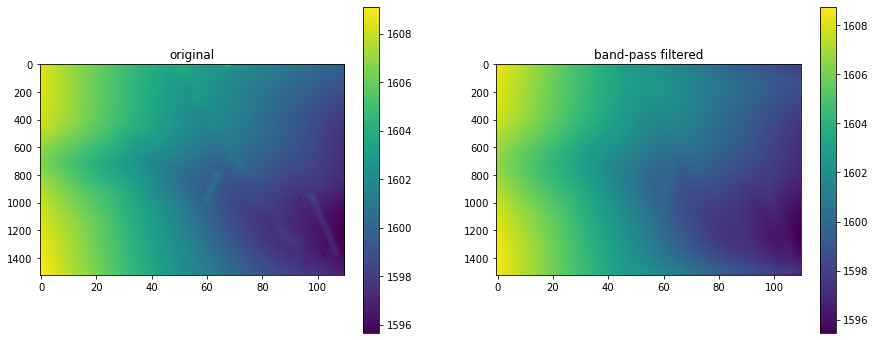

In [881]:
plt.subplot(1,2,1)
plt.imshow(GNSS_drone.T, aspect=0.05)
plt.colorbar()
plt.title("original")

plt.subplot(1,2,2)
plt.imshow(y2.real.T, aspect=0.05)
plt.colorbar()
plt.title("band-pass filtered")



In [573]:
f1=open("3Dmorph_GPR_bpf.txt",'a')
np.savetxt(f1,y2.real.T,"%9.3f", newline="\n")

In [328]:
#extrapolation
#for i in np.arange(0,N,1):
#    ext = 18

#    a = (GNSS_drone[i][ext] - GNSS_drone[i][0]) / ext 
#    a2 = (GNSS_drone[i][-ext] - GNSS_drone[i][-1]) / ext 
   
#    for t in np.arange(0,11,1):
    
#        high[i][t] = GNSS_drone[i][ext] + a * t 
#        high[i][-t] = GNSS_drone[i][-ext] + a2 * t   
#        high[i][0] = GNSS_drone[i][ext] 

In [337]:
#ext = 10
#for i in np.arange(0,N,1):
#    for t in np.arange(0,11,1):
    
#        high[i][t] = GNSS_drone[i][ext] 
#        high[i][-t] = GNSS_drone[i][-ext]   
#        high[i][0] = GNSS_drone[i][ext] 

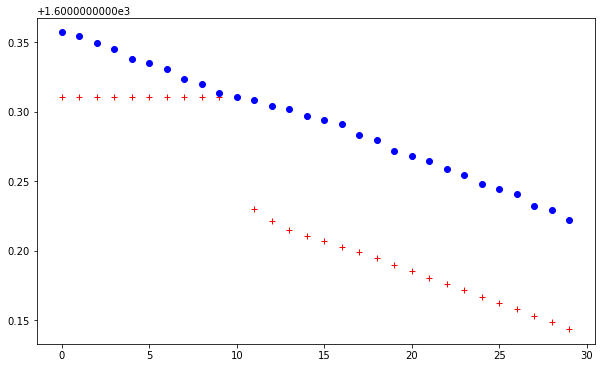

In [331]:
plt.plot(high[nn][0:30],"r+")
plt.plot(GNSS_drone[nn][0:30],"bo")
#plt.plot(high3[100][0:10],"g+")
#plt.ylim(1600.2,1600.4)
#plt.ylim(1599,1610)

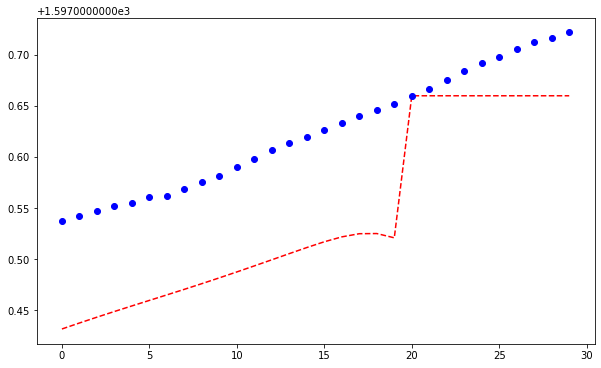

In [332]:
plt.plot(high[nn][-30:],"r--")
plt.plot(GNSS_drone[nn][-30:],"bo")
#plt.plot(high3[100][-10:],"g+")

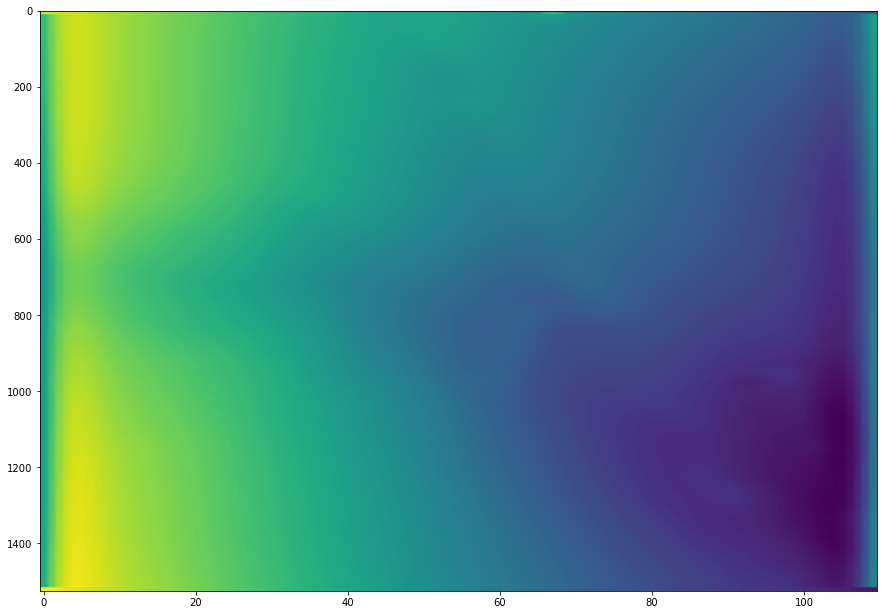

In [333]:
plt.rcParams["figure.figsize"] = (15,30)
plt.imshow(high.T, aspect=0.05)

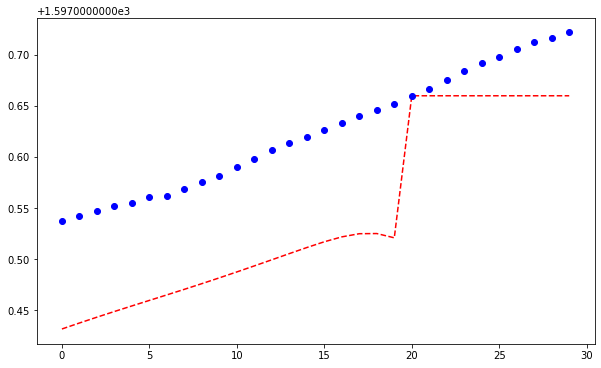

In [334]:
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(high[nn][-30:],"r--")
plt.plot(GNSS_drone[nn][-30:],"bo")
#plt.plot(high3[100][-10:],"g+")

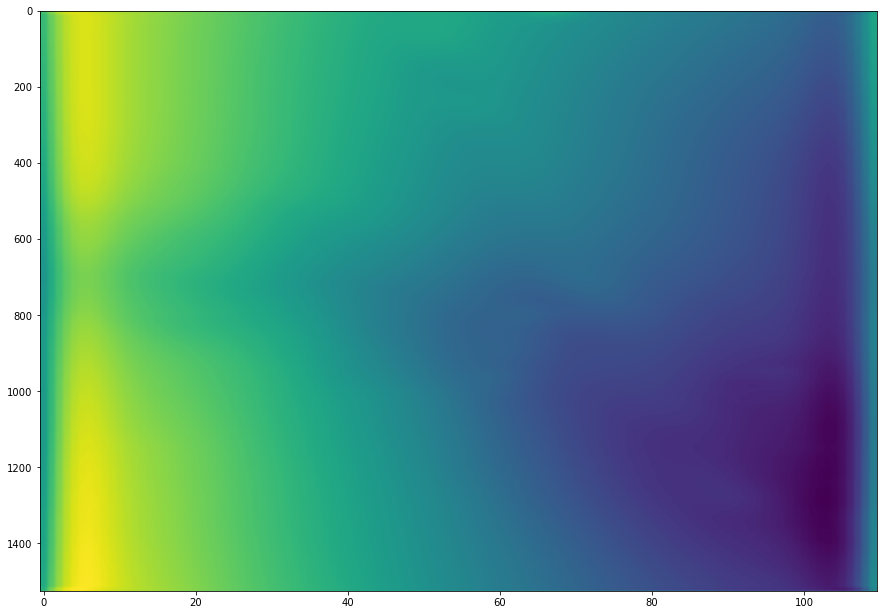

In [336]:
high2 = skimage.filters.butterworth(high, 0.09, False) 

plt.rcParams["figure.figsize"] = (15,30)
plt.imshow(high2.T, aspect=0.05)